Let's generate a catalog of planets, including binary stars.  There are parameters controlling both the planet population and the binary star population:

$$ \theta = (F, \beta, \alpha, f_B, \gamma) $$

$F$, $\beta$ and $\alpha$ are the power-law parameters of the true planet population, $f_B$ is the binary fraction, and $\gamma$ is the mass-ratio power law index.  We want to generate a mock catalog according these parameters, with the Kepler stars as the starting point.  

In [1]:
from kepcatsim import simulate_survey, BURKE_QUERY

`simulate_survey` has all the simulation magic in it. Here's what it does: 

* Selects from the Kepler stellar catalog according to `query`, 
* Simulates binary stars for each of those stars, according to the binary star parameters, 
* Simulates planets according to planet parameters, and
* Dilutes & re-interprets those signals according to the "single star only" hypothesis, keeping only those that are detected.

Here's the Burke query, just for a reminder:

In [2]:
BURKE_QUERY

'4200 <= teff <= 6100 and radius <= 1.15 and dataspan > 365.25*2. and dutycycle > 0.6 and rrmscdpp07p5 <= 1000. and mass > 0'

In [3]:
theta_true = [-0.3, -0.8, -1.5, 0.5, 0.3] #lnF0, beta, alpha, fB, gamma
period_rng = (50,300)
rp_rng = (0.75,20)
mes_threshold = 10.
survey = simulate_survey(theta_true, query=BURKE_QUERY, 
                         period_rng=period_rng, rp_rng=rp_rng, mes_threshold=mes_threshold)

In [4]:
print(len(survey.planets))
survey.planets.head(10)

237


,kepid,koi_max_mult_ev,koi_period,koi_prad,koi_prad_true,star_index,which
0,10130884,46.212725,126.700408,3.395282,3.452732,830,A
1,10088648,27.630868,75.610665,4.061164,6.054655,1214,B
2,10091124,145.456989,69.966637,6.368443,6.368443,3394,A
3,10360722,379.808776,111.090645,11.736556,18.879638,5059,B
4,10422969,59.972700,51.231065,5.720894,5.720894,6016,A
5,10357493,205.974030,282.106960,9.846748,9.846748,6815,A
6,10396517,99.922586,197.868528,5.672146,5.672146,7288,A
7,10292843,383.704116,63.924111,11.856312,11.856312,7989,A
8,10273505,12.864765,131.794374,2.281857,2.281857,9307,A
9,10191527,168.930841,113.226877,7.501915,9.470967,9381,A


In [5]:
survey.planets.groupby('which').count()

,kepid,koi_max_mult_ev,koi_period,koi_prad,koi_prad_true,star_index
which,,,,,,
A,219,219,219,219,219,219
B,18,18,18,18,18,18


That's a bit interesting--- this qualitatively matches what Fressin+ (2013) predict for the fraction of "false positives" from companion star + transiting planet.

Anyway, let's do some inference:

In [10]:
from kepcatsim.inference import DoublePowerLaw, ProbabilisticModel, run_mcmc
import corner
%matplotlib inline

In [6]:
popmodel = DoublePowerLaw(period_rng, rp_rng)
model = ProbabilisticModel(survey, popmodel)
sampler = run_mcmc(theta_true[:3], model)

Running chains...


See what's up:

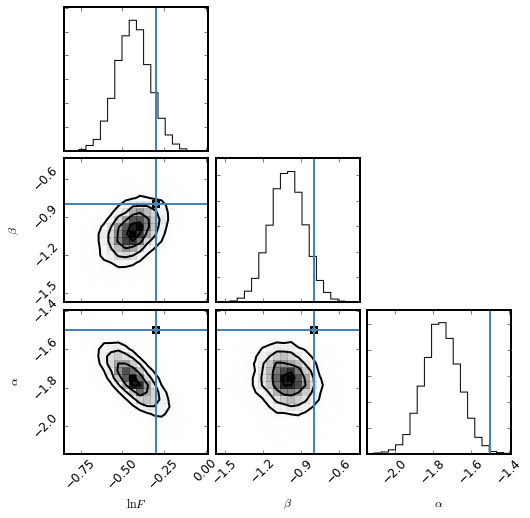

In [7]:
corner.corner(sampler.flatchain, labels=[r"$\ln F$", r"$\beta$", r"$\alpha$"],
                truths=(theta_true[:3]));


OK, great-- as a control, let's do this again, but setting $f_B$ to zero.

Running chains...


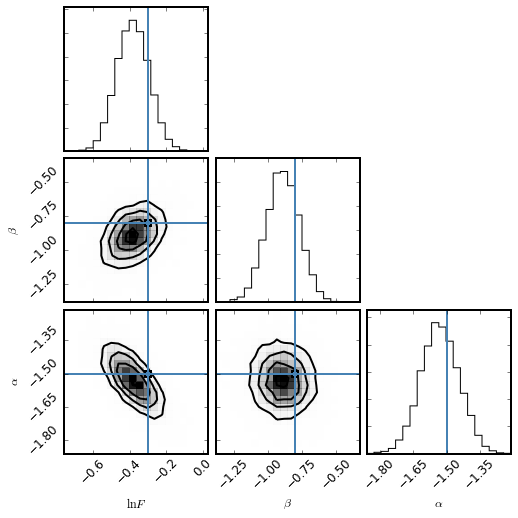

In [9]:
theta_true2 = [-0.3, -0.8, -1.5, 0., 0.3] #lnF0, beta, alpha, fB, gamma
survey2 = simulate_survey(theta_true2, query=BURKE_QUERY, 
                         period_rng=period_rng, rp_rng=rp_rng, mes_threshold=mes_threshold)
model2 = ProbabilisticModel(survey2, popmodel)
sampler2 = run_mcmc(theta_true2[:3], model2)

corner.corner(sampler2.flatchain, labels=[r"$\ln F$", r"$\beta$", r"$\alpha$"],
                truths=(theta_true2[:3]));

OK, now let's see what happens if we interpret $F$ as the *per star* occurrence rate instead of *per system*:

In [ ]:
from kepcatsim.inference import DoublePowerLaw, ProbabilisticModel, run_mcmc
import corner 

popmodel = DoublePowerLaw(period_rng, rp_rng)
theta_true3 = [-0.3, -0.8, -1.5, 0.5, 0.3] #lnF0, beta, alpha, fB, gamma
survey3 = simulate_survey(theta_true3, query=BURKE_QUERY, 
                         period_rng=period_rng, rp_rng=rp_rng, 
                          mes_threshold=mes_threshold, per_star=True)
model3 = ProbabilisticModel(survey3, popmodel)
sampler3 = run_mcmc(theta_true3[:3], model3)

In [12]:
survey3.planets.groupby('which').count()

,kepid,koi_max_mult_ev,koi_period,koi_prad,koi_prad_true,star_index
which,,,,,,
A,298,298,298,298,298,298
B,29,29,29,29,29,29


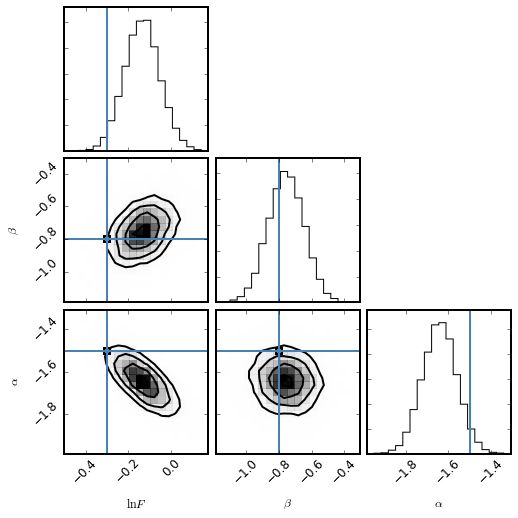

In [11]:
corner.corner(sampler3.flatchain, labels=[r"$\ln F$", r"$\beta$", r"$\alpha$"],
                truths=(theta_true3[:3]));